# <a name="content_list">Home work I (Part II)</a>
   1. [Importing modules, dataset initializing](#importing_modules)
   2. [Features analysing](#features_analysing)
       1. [Age](#age)
       2. [Distance](#distance)
           1. [Haversine function](#haversine_function)
       3. [Average square footage](#average_sqft)
       4. [Square footage of all basements](#all_basement_sqft)
       5. [Date](#date)
       6. [Renovation square footage difference](#sqft_15_diff)
   3. [Clustering](#clustering)
       1. [Districts](#districts)
           1. [Districts clustering by grade](#d_clustering_by_grade)
           2. [Districts clustering by location](#d_clustering_by_location)
       2. [Neighborhoods](#neighborhoods)
           1. [Neigborhoods clustering by grade](#n_clustering_by_grade)
           2. [Neigborhoods clustering by location](#n_clustering_by_location)
   4. [Linear Regression](#linear_regression)
   5. [Features usefulness analysis](#features_usefulness_analys)
       1. [Useless feature 1](#useless_feature_1)
   6. [Logistic Regression](#logistic_regression) 
       1. [Useless feature 2](#useless_feature_2)
   7. [Free parameter analysis](#free_parameter_analysis)
   8. [Logistic regression result](#logistic_regression_result)
   9. [Decision tree](#decision_tree)
       1. [Decision tree result](#dt_result)
   10. [Summary](#summary)
   
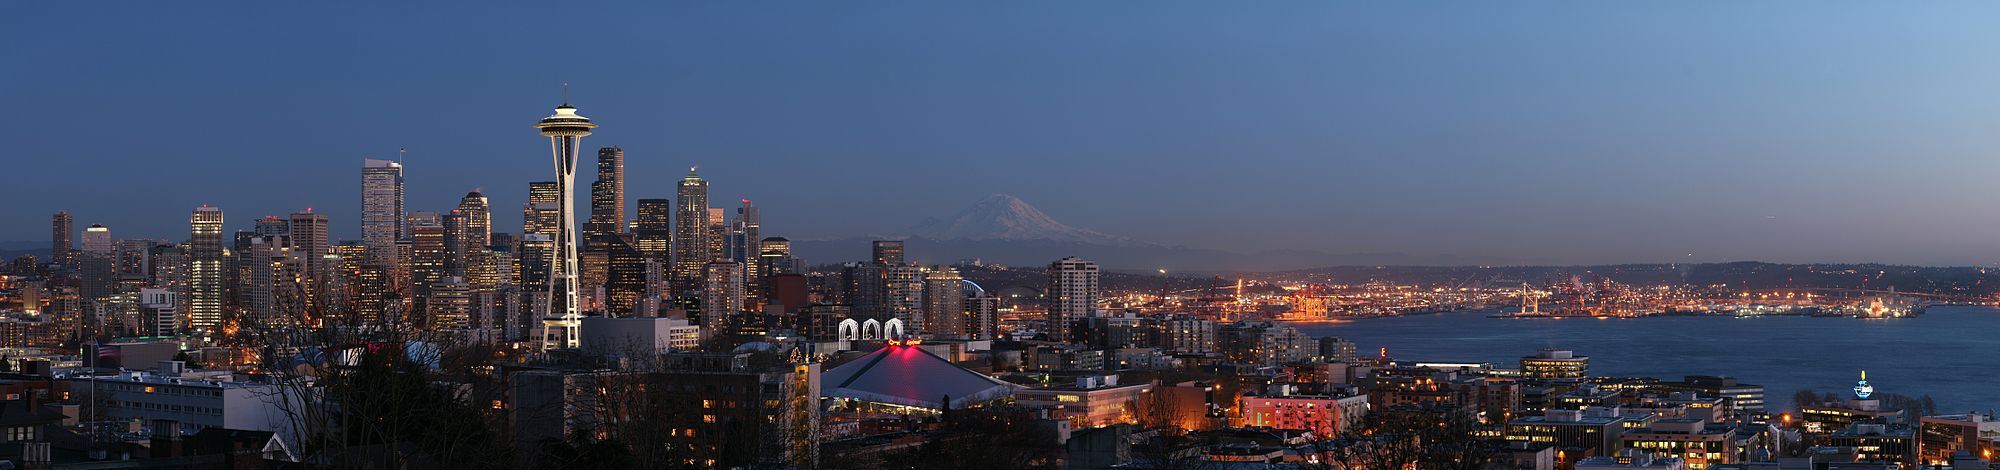
picture from: https://en.wikipedia.org/wiki/Seattle#/media/File:Seattle_3.jpg

Course: Introduction in machine learning

Lecturer: Taras Lehinevych

Author: Kyryll Vasylenko

# <a name="importing_modules">Importing modules, dataset initializing</a>

[Back to content list](#content_list)

In [1]:
#Importing
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from math import radians, cos, sin, asin, sqrt, log
from datetime import datetime
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn import datasets, linear_model
from sklearn.multiclass import OneVsRestClassifier
from sklearn.multiclass import OneVsOneClassifier
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import accuracy_score
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score
#for decision tree
from sklearn.tree import DecisionTreeRegressor
#for clustering\graphics
%matplotlib inline
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans

# Dataset reading
frame = pd.read_csv('house_data.csv')

# <a name="features_analysing">Features analysing</a>

[Back to content list](#content_list)

In [2]:
frame.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21613 entries, 0 to 21612
Data columns (total 21 columns):
id               21613 non-null int64
date             21613 non-null object
price            21613 non-null float64
bedrooms         21613 non-null int64
bathrooms        21613 non-null float64
sqft_living      21613 non-null int64
sqft_lot         21613 non-null int64
floors           21613 non-null float64
waterfront       21613 non-null int64
view             21613 non-null int64
condition        21613 non-null int64
grade            21613 non-null int64
sqft_above       21613 non-null int64
sqft_basement    21613 non-null int64
yr_built         21613 non-null int64
yr_renovated     21613 non-null int64
zipcode          21613 non-null int64
lat              21613 non-null float64
long             21613 non-null float64
sqft_living15    21613 non-null int64
sqft_lot15       21613 non-null int64
dtypes: float64(5), int64(15), object(1)
memory usage: 3.5+ MB


#### <a name="age">Age</a>

Age of house starting from renovation date or if house wasn't renovated - staring from year of building

As we can see, yr_renovated has 0 values, so, we can replase them with yr_build values and with formula below we will have house age

age = yr_renovated - current_year

In [3]:
current_year = datetime.now().year
for i, x in frame[['yr_built']].itertuples():
    if(frame.at[i, 'yr_renovated'] == 0):
        frame.at[i, 'yr_renovated'] = x
    frame.at[i, 'age'] = current_year - frame.at[i, 'yr_renovated']

#### <a name="distance">Distance</a>

Let's get from lot and lang coordinate and count distance from center of Seattle!

My conclusion - than house farther from the center, than house price lower.

##### <a name="haversine_function">Haversine auxiliary function</a>
*Calculates the great circle distance between two points 
on the earth (specified in decimal degrees)*

$long$ - Longitude

$lat$ - Latitude

$r = 6371$ - Earth radius in kilometers

$\Delta lat = {lat_2 - lat_1} $

$\Delta long = {long_2 - long_1} $

**haversine** = $2r\arcsin{(\sqrt{\sin^2{(\frac{\Delta lat}{2})} + \cos{(lat_1)} \cos{(lat_2)} \sin^2{(\frac{\Delta long}{2})}})}$

In [4]:
def haversine(lon2, lat2):
    # Seattle center coordinates
    centerLon = -122.352033
    centerLat = 47.622451

    # convert decimal degrees to radians 
    lon1, lat1, lon2, lat2 = map(radians, [centerLon, centerLat, lon2, lat2])

    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    r = 6371 # Radius of earth in kilometers, 3956 for miles
    return c * r

In [5]:
for i, lat, long in frame[['lat','long']].itertuples():
    frame.at[i,'distance'] = haversine(long, lat)

#### <a name="average_sqft">Average square footage</a>

If house has average square footage by room or by floor n, this house can be worst than house with average square footage m, where m > n

In [6]:
for i, f, a, b, c, d in frame[['floors','bedrooms','bathrooms','sqft_above','sqft_basement']].itertuples():
    frame.at[i,'average_sqft_by_room'] = ((c+d)/((a+b)+1))#+1 because house can be without bedrooms or bathrooms
    frame.at[i,'average_sqft_by_floor'] = ((c+d)/f)

#### <a name="all_basement_sqft">All basements square footage</a>

We have sqft_basement field - information about house basement, we also have house floors count, we can multiply this parameters and get house sqft for all floors

Suggestion: Than more floors, than biggest price of house

In [7]:
for i, f, sqft in frame[['floors','sqft_basement']].itertuples():
    frame.at[i,'sqft_floors_mult_basement'] = f*sqft

#### <a name="date">Date</a>

- We can't create regression by date object
- Sales starts in 2014 year
- Not effective convert date to millis or seconds or days, because generally house prices can't change each second or each day
- Each year - too large
- Each month - sounds good

In [8]:
frame['date'] = pd.to_datetime(frame['date'])
for i, d in frame[['date']].itertuples():
    frame.at[i, 'mnths'] = (d.year - 2014)*12 + d.month

#Delete useless field
del frame['date']

#### <a name="sqft_15_diff">Square footage difference</a>

Created difference between sqft in 15 year and sqft living.

We have some result of reonvation for sque.

In [9]:
#Convert difference between sqft_living15 and sqft_living to ren_living_diff - sqft difference after renovation 
for i, l, lo, l15, lo15 in frame[['sqft_living','sqft_lot','sqft_living15','sqft_lot15']].itertuples():
    frame.at[i,'ren_living_diff'] = l15-l
    frame.at[i,'ren_lot_diff'] = lo15-lo

# <a name="clustering">Clustering</a>

[Back to content list](#content_list)

## <a name="districts">Districts</a>

- Seattle has 7 districts
- So, I will split lots into seven clusters by coordinates
    - Firstly I will split into clasters by location
    - And I will split by grades and distance, I think, can be grade correlation between house grade and house distantion from center. 
    
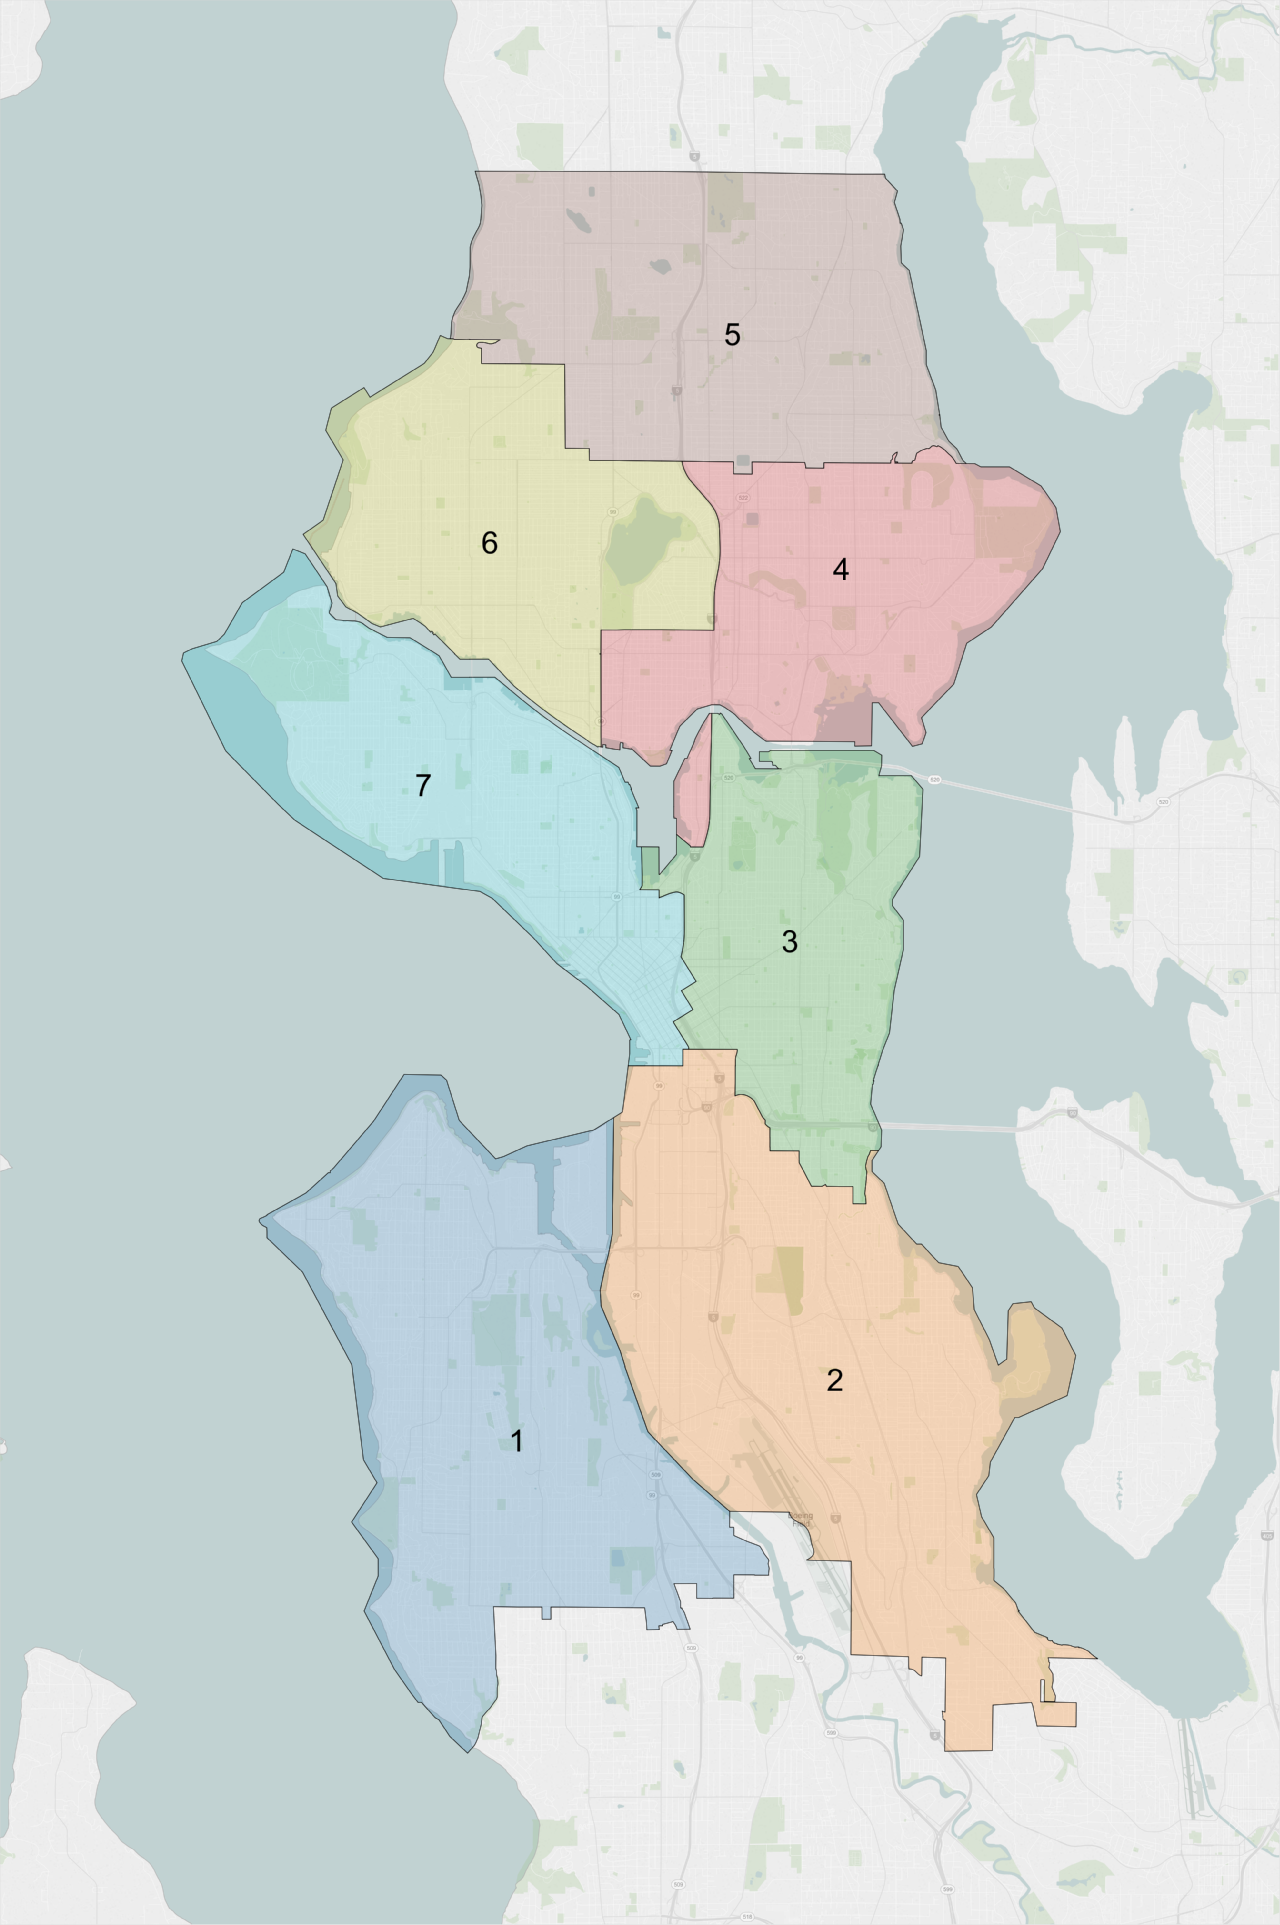
picture from: https://en.wikipedia.org/wiki/Seattle

[Back to content list](#content_list)

# <a name="d_clustering_by_grade">Districts clustering by grade</a>

[Back to content list](#content_list)

In [10]:
# Simple points visualization by x and y coordinates
def draw(x, y):
    data = frame[[x,y]].values
    plt.scatter(data[:, 0], data[:, 1], s=5, alpha=.4)
    plt.xlabel(x)
    plt.ylabel(y)
    plt.show()
    return data

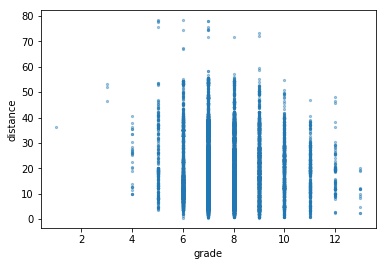

In [11]:
# Distance by price visualization
dist_grade = draw('grade', 'distance')

In [12]:
# Train and centers initializing
k_means_district = KMeans(n_clusters=7)
k_means_district.fit(dist_grade)
centers = k_means_district.cluster_centers_

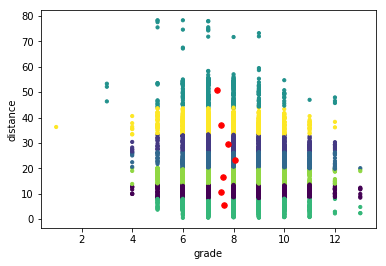

In [13]:
# Districts clustering by price visualization
plt.xlabel("grade")
plt.ylabel("distance")
plt.scatter(dist_grade[:, 0], dist_grade[:, 1], c=k_means_district.predict(dist_grade), s=10, alpha=1)
plt.scatter(centers[:, 0], centers[:, 1], c='red', s=30, alpha=1)

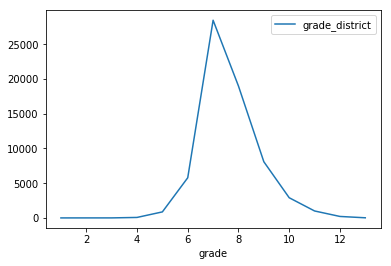

In [14]:
# Splitting lots into districts
distance_clusters = k_means_district.predict(dist_grade)
for i, d in frame[['distance']].itertuples():
    frame.at[i,'grade_district'] = distance_clusters[i]
    
pd.DataFrame({
    'grade': frame['grade'],
    'grade_district': frame['grade_district']
    }).groupby('grade').sum().plot()
#Seems like normal distribution

# <a name="d_clustering_by_location">Districts clustering by location</a>

[Back to content list](#content_list)

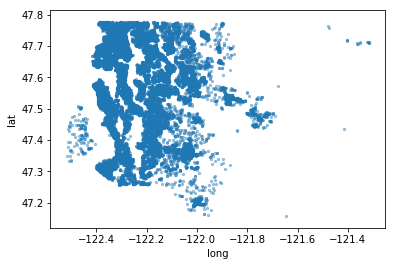

In [15]:
# Coordinates visualization
coordinates = draw('long','lat')

In [16]:
# Train and centers initialization 
k_means_district.fit(coordinates)
centers = k_means_district.cluster_centers_

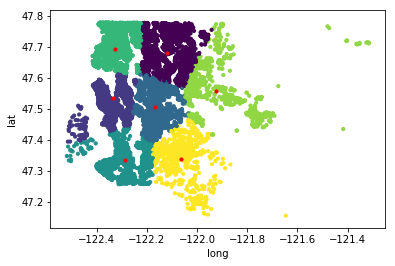

In [17]:
plt.xlabel("long")
plt.ylabel("lat")
plt.scatter(coordinates[:, 0], coordinates[:, 1], c=k_means_district.predict(coordinates), s=10, alpha=1)
plt.scatter(centers[:, 0], centers[:, 1], c='red', s=10, alpha=1)

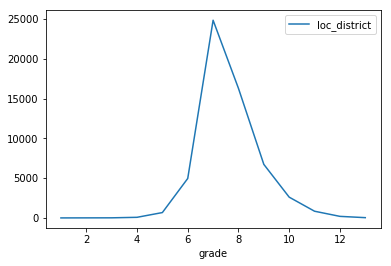

In [18]:
# Splitting lots into districts
loc_clusters = k_means_district.predict(coordinates)
for i, lat, long in frame[['lat','long']].itertuples():
    frame.at[i,'loc_district'] = loc_clusters[i]
pd.DataFrame({
    'grade': frame['grade'],
    'loc_district': frame['loc_district']
    }).groupby('grade').sum().plot()

# <a name="neighborhoods">Neighborhoods</a>

- And also Seattle has 127 neighborhoods
- So, I will split coordinates into 127 clusters, because clustering by neighborhoods can give us more presicion than clustering by districts
    - Split into clasters by location
    - Split by grade
    
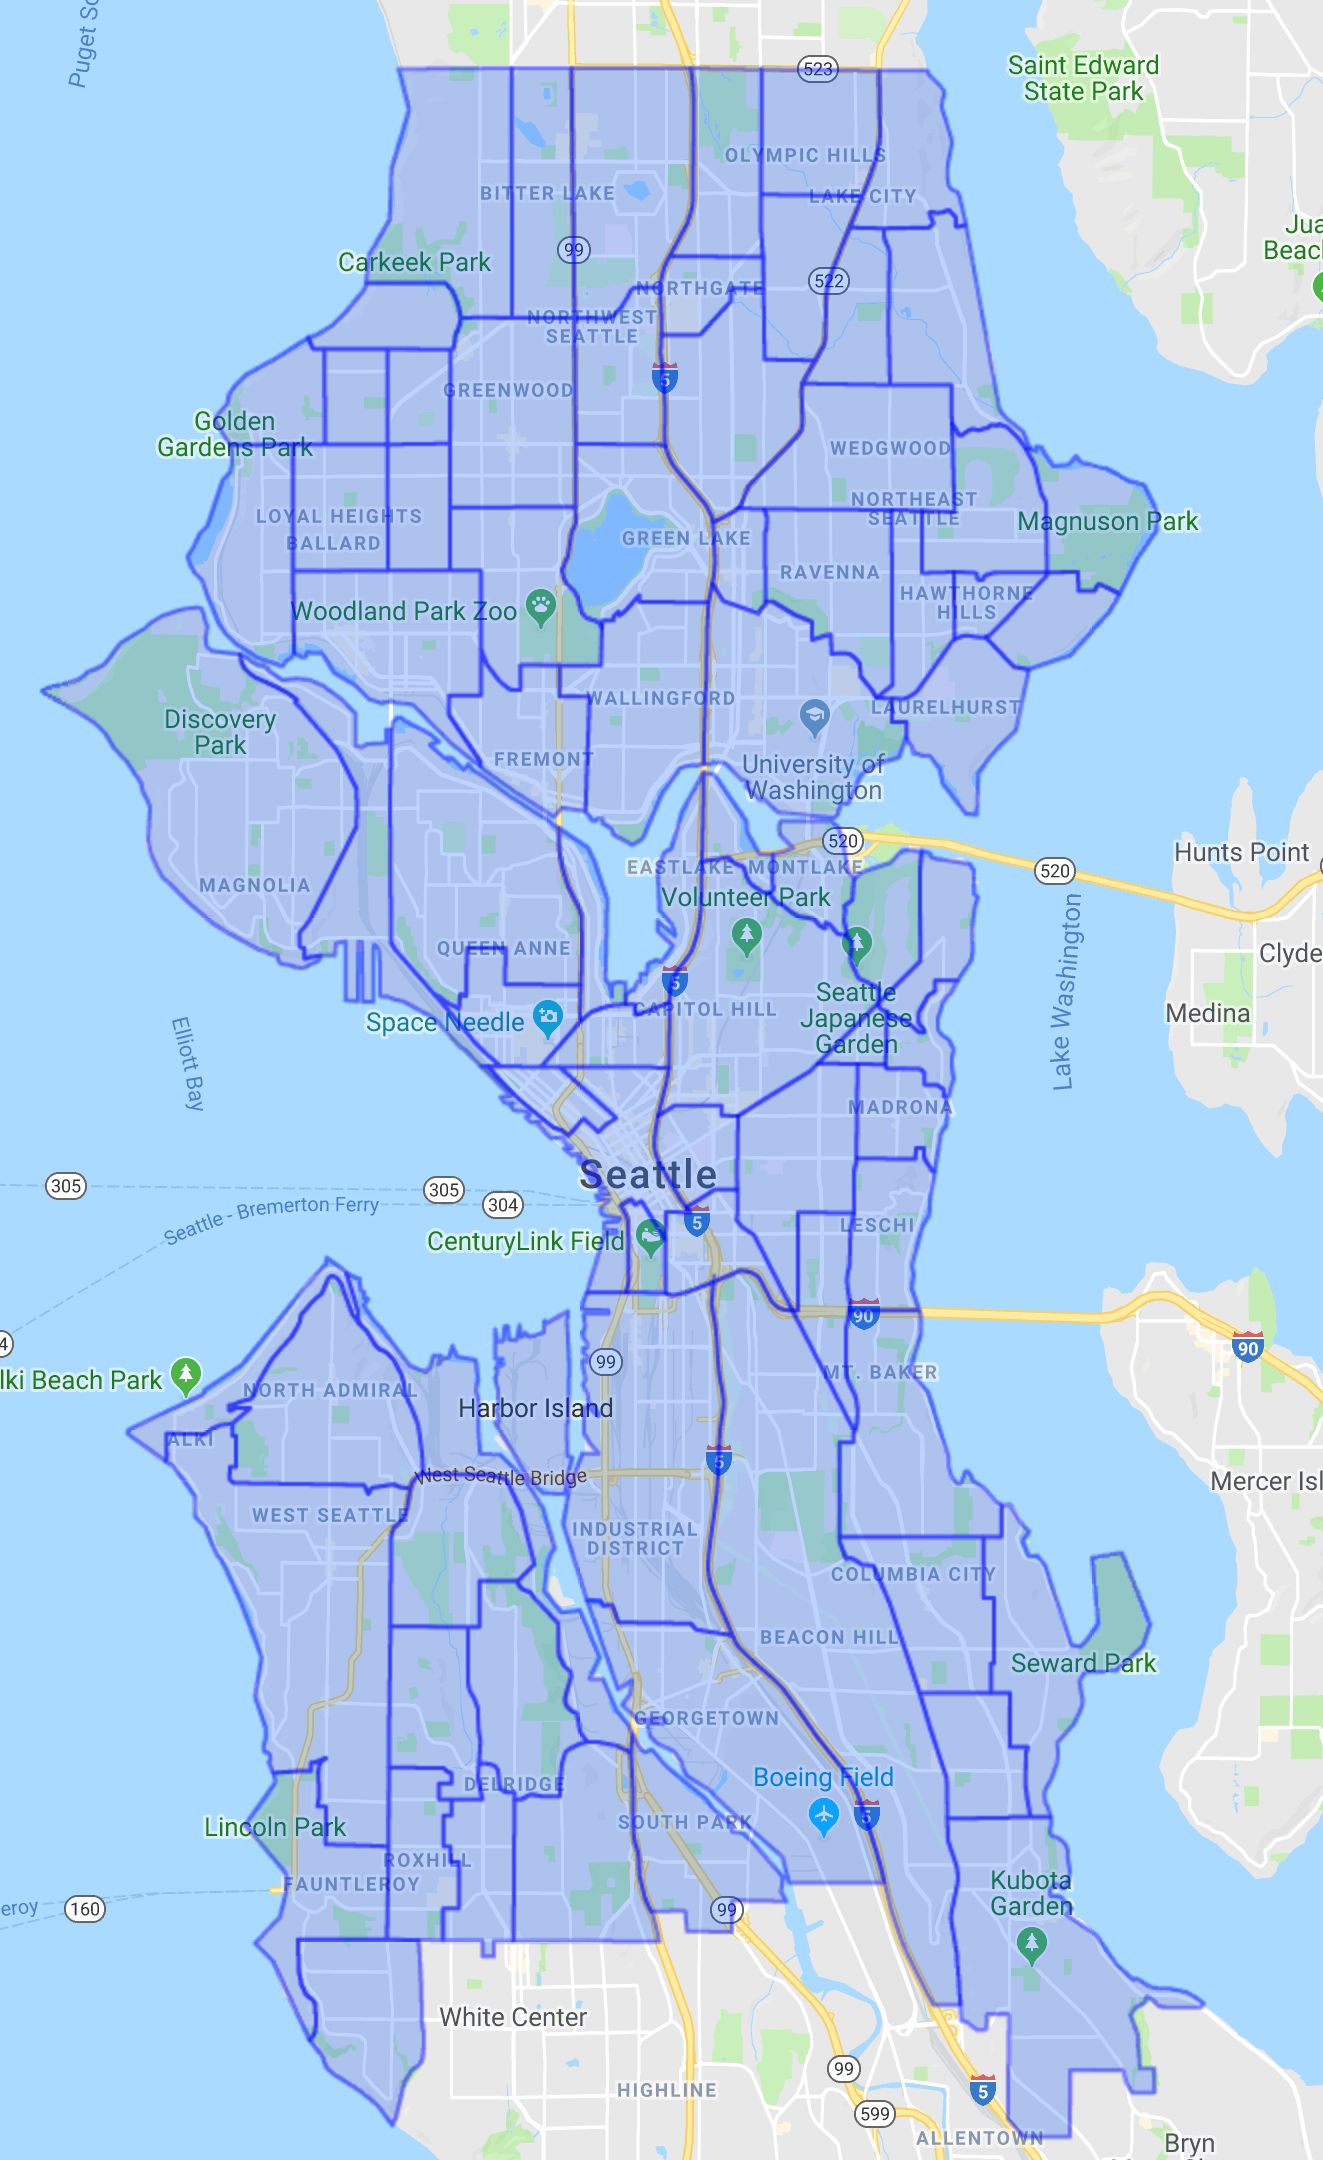
picture from: https://seattle.findwell.com/seattle-neighborhoods/
    
[Back to content list](#content_list)

## <a name="n_clustering_by_grade">Neigborhoods clustering by grade</a>

[Back to content list](#content_list)

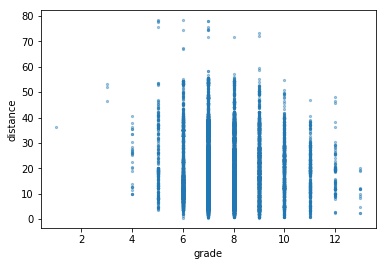

In [19]:
# Distance by price visualization
dist_grade = draw('grade','distance')

In [20]:
# Train and centers initializing
k_means_neighborhoods = KMeans(n_clusters=127)
k_means_neighborhoods.fit(dist_grade)
centers = k_means_neighborhoods.cluster_centers_

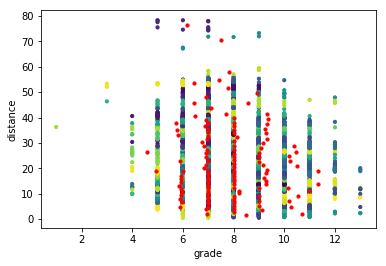

In [21]:
# Neigborhoods clustering by price visualization
plt.xlabel("grade")
plt.ylabel("distance")
plt.scatter(dist_grade[:, 0], dist_grade[:, 1], c=k_means_neighborhoods.predict(dist_grade), s=10, alpha=1)
plt.scatter(centers[:, 0], centers[:, 1], c='red', s=10, alpha=1)

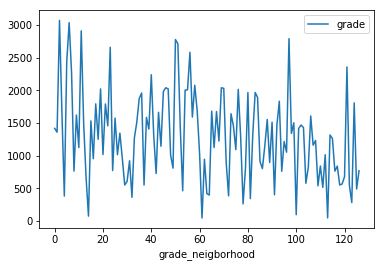

In [22]:
# Splitting lots into neigborhoods
distance_clusters = k_means_neighborhoods.predict(dist_grade)
for i, d in frame[['distance']].itertuples():
    frame.at[i,'grade_neigborhood'] = distance_clusters[i]

#Visualisation
pd.DataFrame({
    'grade': frame['grade'],
    'grade_neigborhood': frame['grade_neigborhood']
    }).groupby('grade_neigborhood').sum().plot()

# <a name="n_clustering_by_location">Neigborhoods clustering by location</a>

[Back to content list](#content_list)

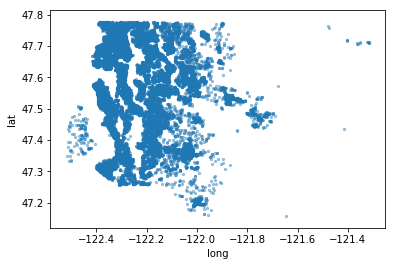

In [23]:
# Coordinates visualization
coordinates = draw('long','lat')

In [24]:
# Train and centers initialization 
k_means_district = KMeans(n_clusters=127)
k_means_district.fit(coordinates)
centers = k_means_district.cluster_centers_

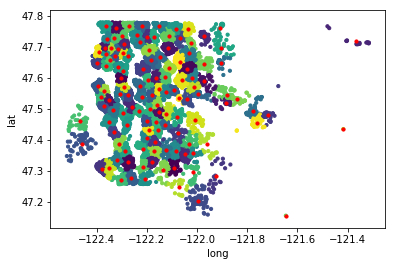

In [25]:
plt.xlabel("long")
plt.ylabel("lat")
plt.scatter(coordinates[:, 0], coordinates[:, 1], c=k_means_district.predict(coordinates), s=10, alpha=1)
plt.scatter(centers[:, 0], centers[:, 1], c='red', s=10, alpha=1)

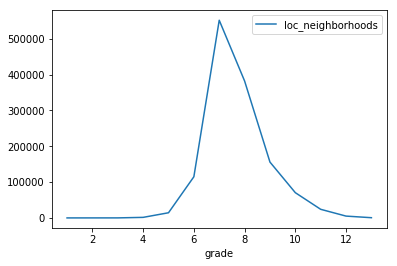

In [26]:
# Splitting lots into districts
loc_clusters = k_means_district.predict(coordinates)
for i, lat, long in frame[['lat','long']].itertuples():
    frame.at[i,'loc_neighborhoods'] = loc_clusters[i]
pd.DataFrame({
    'grade': frame['grade'],
    'loc_neighborhoods': frame['loc_neighborhoods']
    }).groupby('grade').sum().plot()

# <a name="linear_regression">Linear Regression</a>

[Back to content list](#content_list)

In [27]:
# Create linear regression object
regr = linear_model.LinearRegression()

In [28]:
def split(frame, features_columns, target_column):
    # Split the frame into training/testing sets
    train_frame, test_frame = train_test_split(frame, test_size = 0.2, random_state=49)
    
    train_features = train_frame.iloc[:,features_columns]
    test_features = test_frame.iloc[:,features_columns]
    
    train_target = train_frame[target_column]
    test_target = test_frame[target_column]
    return train_features, train_target, test_features, test_target

In [29]:
#Fit and visualisation model by single feature
def fit_and_test_visualisation(frm, feature_column, target):
    train_features, train_target, test_features, test_target = split(frame, feature_column, target)
    
    regr.fit(train_features, train_target)
    train_prediction = regr.predict(train_features)
    test_prediction = regr.predict(test_features)
    
    print('Feature # {} : {}'.format(feature_column[0], frm.columns[feature_column]))
    
    print(":::Train:::")
    mse = mean_squared_error(train_target, train_prediction)
    r2s = r2_score(train_target, train_prediction)
    print("Mean squared error: %.2f" % mse)
    print('Variance score: %.2f' % r2s)
    
    mse = mean_squared_error(test_target, test_prediction)
    r2s = r2_score(test_target, test_prediction)
    print(":::Test:::")
    print("Mean squared error: %.2f" % mse)
    print('Variance score: %.2f' % r2s)
    
    
    plt.scatter(test_features, test_target,  color='black')
    plt.plot(test_features, test_prediction, color='blue', linewidth=3)
    plt.xticks(())
    plt.yticks(())
    plt.show()

# <a name="features_usefulness_analys">Features usefulness analysis</a>

Let's build for each feature linear regression model and watch at the results

[Back to content list](#content_list)

Feature # 0 : Index(['id'], dtype='object')
:::Train:::
Mean squared error: 1.37
Variance score: 0.00
:::Test:::
Mean squared error: 1.43
Variance score: 0.00


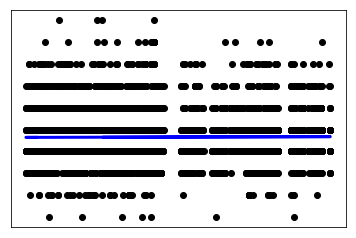

Feature # 1 : Index(['price'], dtype='object')
:::Train:::
Mean squared error: 0.76
Variance score: 0.44
:::Test:::
Mean squared error: 0.78
Variance score: 0.45


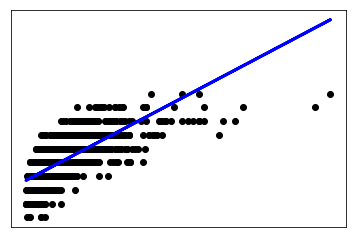

Feature # 2 : Index(['bedrooms'], dtype='object')
:::Train:::
Mean squared error: 1.20
Variance score: 0.12
:::Test:::
Mean squared error: 1.23
Variance score: 0.15


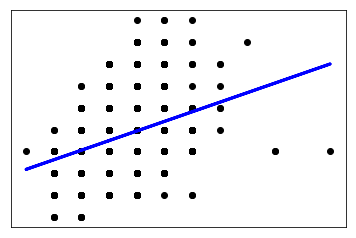

Feature # 3 : Index(['bathrooms'], dtype='object')
:::Train:::
Mean squared error: 0.77
Variance score: 0.44
:::Test:::
Mean squared error: 0.78
Variance score: 0.45


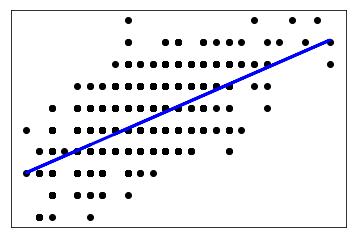

Feature # 4 : Index(['sqft_living'], dtype='object')
:::Train:::
Mean squared error: 0.58
Variance score: 0.58
:::Test:::
Mean squared error: 0.58
Variance score: 0.60


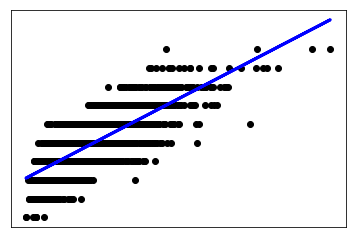

Feature # 5 : Index(['sqft_lot'], dtype='object')
:::Train:::
Mean squared error: 1.35
Variance score: 0.01
:::Test:::
Mean squared error: 1.42
Variance score: 0.01


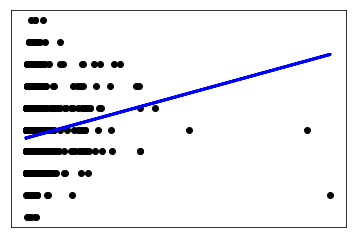

Feature # 6 : Index(['floors'], dtype='object')
:::Train:::
Mean squared error: 1.08
Variance score: 0.21
:::Test:::
Mean squared error: 1.13
Variance score: 0.21


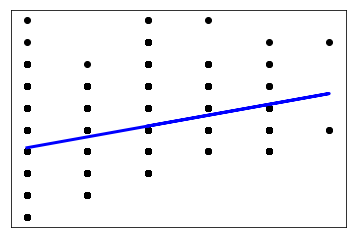

Feature # 7 : Index(['waterfront'], dtype='object')
:::Train:::
Mean squared error: 1.36
Variance score: 0.01
:::Test:::
Mean squared error: 1.42
Variance score: 0.01


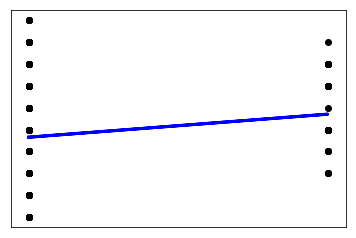

Feature # 8 : Index(['view'], dtype='object')
:::Train:::
Mean squared error: 1.28
Variance score: 0.06
:::Test:::
Mean squared error: 1.34
Variance score: 0.07


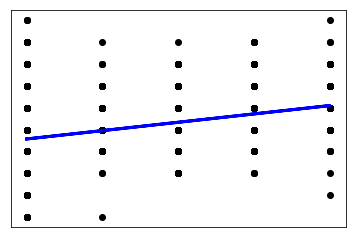

Feature # 9 : Index(['condition'], dtype='object')
:::Train:::
Mean squared error: 1.34
Variance score: 0.02
:::Test:::
Mean squared error: 1.41
Variance score: 0.02


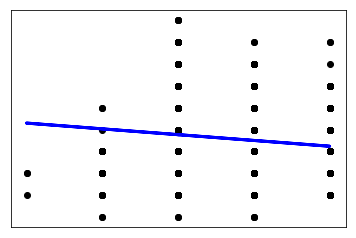

Feature # 10 : Index(['grade'], dtype='object')
:::Train:::
Mean squared error: 0.00
Variance score: 1.00
:::Test:::
Mean squared error: 0.00
Variance score: 1.00


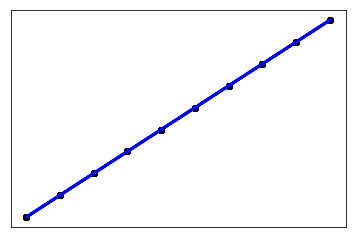

Feature # 11 : Index(['sqft_above'], dtype='object')
:::Train:::
Mean squared error: 0.59
Variance score: 0.57
:::Test:::
Mean squared error: 0.58
Variance score: 0.59


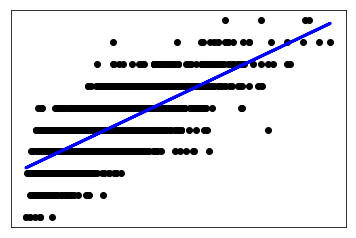

Feature # 12 : Index(['sqft_basement'], dtype='object')
:::Train:::
Mean squared error: 1.33
Variance score: 0.03
:::Test:::
Mean squared error: 1.40
Variance score: 0.02


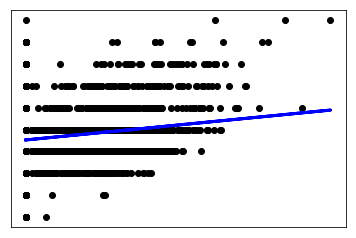

Feature # 13 : Index(['yr_built'], dtype='object')
:::Train:::
Mean squared error: 1.09
Variance score: 0.20
:::Test:::
Mean squared error: 1.15
Variance score: 0.20


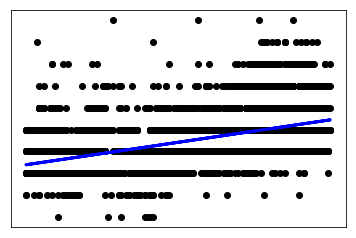

Feature # 14 : Index(['yr_renovated'], dtype='object')
:::Train:::
Mean squared error: 1.08
Variance score: 0.21
:::Test:::
Mean squared error: 1.13
Variance score: 0.21


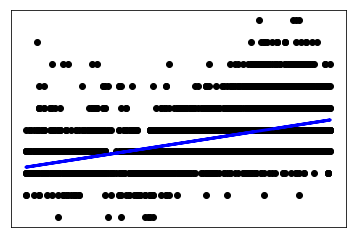

Feature # 15 : Index(['zipcode'], dtype='object')
:::Train:::
Mean squared error: 1.32
Variance score: 0.03
:::Test:::
Mean squared error: 1.38
Variance score: 0.04


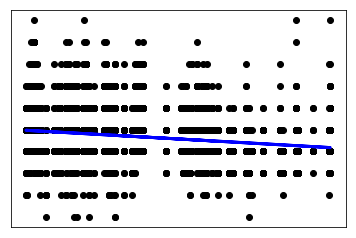

Feature # 16 : Index(['lat'], dtype='object')
:::Train:::
Mean squared error: 1.35
Variance score: 0.01
:::Test:::
Mean squared error: 1.42
Variance score: 0.01


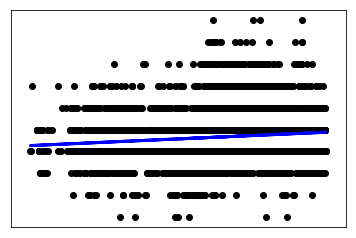

Feature # 17 : Index(['long'], dtype='object')
:::Train:::
Mean squared error: 1.32
Variance score: 0.04
:::Test:::
Mean squared error: 1.37
Variance score: 0.04


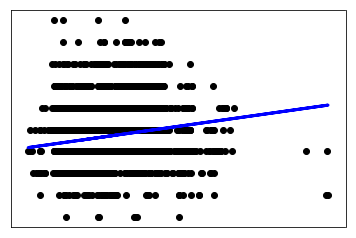

Feature # 18 : Index(['sqft_living15'], dtype='object')
:::Train:::
Mean squared error: 0.68
Variance score: 0.50
:::Test:::
Mean squared error: 0.67
Variance score: 0.53


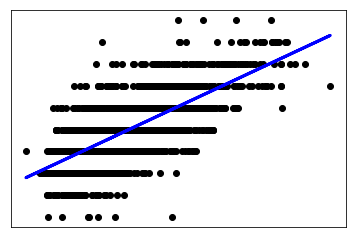

Feature # 19 : Index(['sqft_lot15'], dtype='object')
:::Train:::
Mean squared error: 1.35
Variance score: 0.01
:::Test:::
Mean squared error: 1.41
Variance score: 0.02


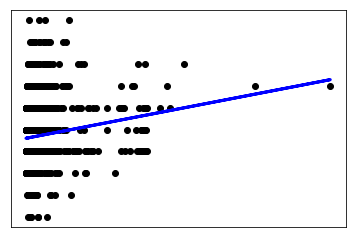

Feature # 20 : Index(['age'], dtype='object')
:::Train:::
Mean squared error: 1.08
Variance score: 0.21
:::Test:::
Mean squared error: 1.13
Variance score: 0.21


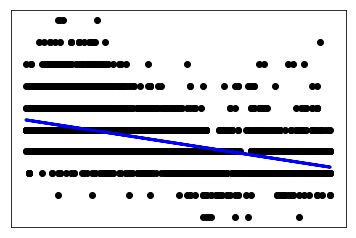

Feature # 21 : Index(['distance'], dtype='object')
:::Train:::
Mean squared error: 1.37
Variance score: 0.00
:::Test:::
Mean squared error: 1.43
Variance score: 0.00


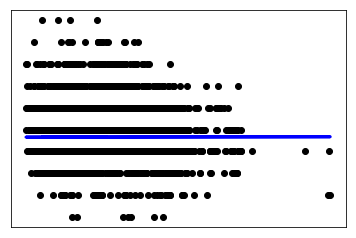

Feature # 22 : Index(['average_sqft_by_room'], dtype='object')
:::Train:::
Mean squared error: 0.87
Variance score: 0.36
:::Test:::
Mean squared error: 0.81
Variance score: 0.44


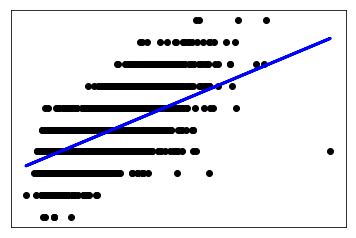

Feature # 23 : Index(['average_sqft_by_floor'], dtype='object')
:::Train:::
Mean squared error: 1.18
Variance score: 0.14
:::Test:::
Mean squared error: 1.23
Variance score: 0.15


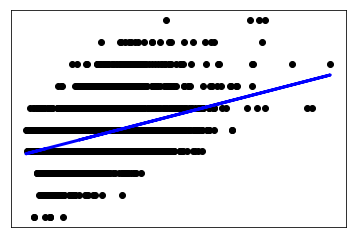

Feature # 24 : Index(['sqft_floors_mult_basement'], dtype='object')
:::Train:::
Mean squared error: 1.27
Variance score: 0.07
:::Test:::
Mean squared error: 1.34
Variance score: 0.06


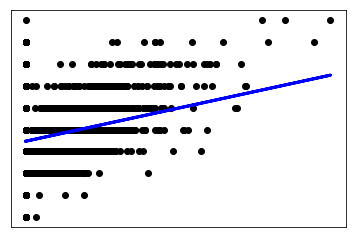

Feature # 25 : Index(['mnths'], dtype='object')
:::Train:::
Mean squared error: 1.37
Variance score: 0.00
:::Test:::
Mean squared error: 1.43
Variance score: 0.00


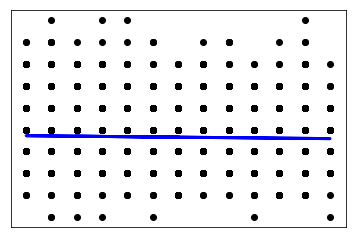

Feature # 26 : Index(['ren_living_diff'], dtype='object')
:::Train:::
Mean squared error: 1.20
Variance score: 0.13
:::Test:::
Mean squared error: 1.26
Variance score: 0.12


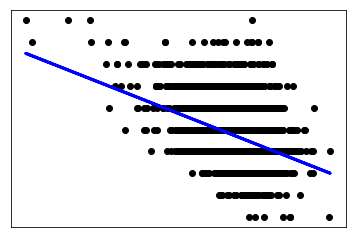

Feature # 27 : Index(['ren_lot_diff'], dtype='object')
:::Train:::
Mean squared error: 1.36
Variance score: 0.00
:::Test:::
Mean squared error: 1.44
Variance score: -0.00


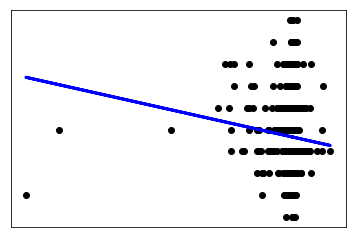

Feature # 28 : Index(['grade_district'], dtype='object')
:::Train:::
Mean squared error: 1.37
Variance score: 0.00
:::Test:::
Mean squared error: 1.43
Variance score: 0.00


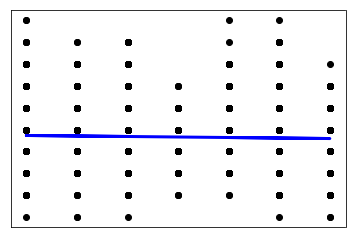

Feature # 29 : Index(['loc_district'], dtype='object')
:::Train:::
Mean squared error: 1.37
Variance score: 0.00
:::Test:::
Mean squared error: 1.43
Variance score: 0.00


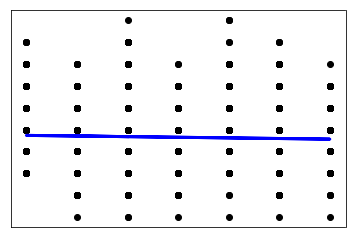

Feature # 30 : Index(['grade_neigborhood'], dtype='object')
:::Train:::
Mean squared error: 1.36
Variance score: 0.01
:::Test:::
Mean squared error: 1.43
Variance score: 0.00


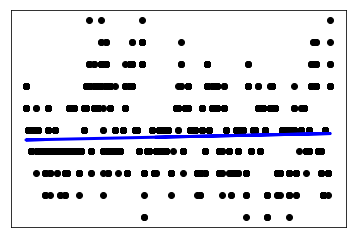

Feature # 31 : Index(['loc_neighborhoods'], dtype='object')
:::Train:::
Mean squared error: 1.37
Variance score: 0.00
:::Test:::
Mean squared error: 1.43
Variance score: -0.00


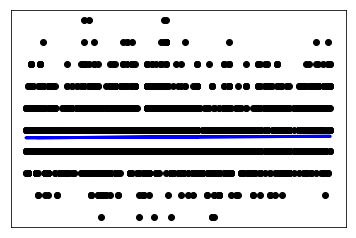

In [30]:
for x in [*range(frame.columns.size)]:
    fit_and_test_visualisation(frame, [x], 'grade')

## <a name="useless_feature_1">Useless feature 1</a>

We built linear regression for target y by single x feature

Suggestion:

When variance score of linear regression by **x** feature ~0.00 and mean squared error very high* - feature useless and can't really increase variance of prediction.

In case with grades we have more influence from other fields, we even don't have variance score < 0.01 and can say something only about id, id - useless

If useless only id, then other features always help us increase accurasy, sounds good, but let's try analyse our features once more.

# <a name="logistic_regression">Logistic Regression</a>

[Back to content list](#content_list)

In [31]:
def train_logistic_regression_model(train_features, train_target, test_features, test_target, C): 
    poly = PolynomialFeatures(degree=1)
    train_poly = poly.fit_transform(train_features)
    test_poly = poly.fit_transform(test_features)

    logit = LogisticRegression(C=C, random_state=49)
    logit.fit(train_poly, train_target)

    score_train = round(logit.score(train_poly, train_target), 3)
    score_test = round(logit.score(test_poly, test_target), 3)
    return score_train, score_test

## <a name="useless_feature_2">Useless feature 2</a>

For finding useless feature **x** let's do several things:

1. Fit model without **x** feature and get $test1$ and $train1$ score
2. Fit model with all features and get $test2$ and $train2$ score
3. After that we can get $\Delta test = test2-test1$ and $\Delta train = train2-train1$
4. **if** $\Delta test < 0$ => feature useless **else** feature usefull

In [32]:
def brute_analyse():
    C = 9000
    useless_features = []

    for col in frame.columns:
        #copy the main data frame
        tmp = frame.copy()
        #init features and target columns
        target_index = tmp.columns.get_loc('grade')
        features_columns = [*range(tmp.columns.size)]
        target_column = 'grade'
        features_columns.remove(target_index)
        #split frame
        train_features, train_target, test_features, test_target = split(tmp, features_columns, target_column)
        #train
        train_score_with, test_score_with = train_logistic_regression_model(train_features, train_target, test_features, test_target, C)
        if(col!='grade'):
            del tmp[col]
        #reinitialize features
        target_index = tmp.columns.get_loc('grade')
        features_columns = [*range(tmp.columns.size)]
        target_column = 'grade'
        features_columns.remove(target_index)

        #split frame
        train_features, train_target, test_features, test_target = split(tmp, features_columns, target_column)
        #train
        train_score_without, test_score_without = train_logistic_regression_model(train_features, train_target, test_features, test_target, C)
        #print ouptut
        print("column: {}\n".format(col))
        print("test_score_with: {}\ntest_score_without: {}\n".format(test_score_with,test_score_without))
        print("train_score_with: {}\ntrain_score_without{}\n".format(train_score_with,train_score_without))
        delta_train_score = train_score_with-train_score_without
        delta_test_score = test_score_with-test_score_without
        print("delta_test_score: {}\ndelta_train_score: {}\n\n".format(delta_test_score,delta_train_score))
        if(delta_test_score < 0):
            useless_features.append(col)
    return useless_features

In [33]:
useless_features = brute_analyse()

column: id

test_score_with: 0.407
test_score_without: 0.562

train_score_with: 0.406
train_score_without0.564

delta_test_score: -0.15500000000000008
delta_train_score: -0.15799999999999992


column: price

test_score_with: 0.407
test_score_without: 0.413

train_score_with: 0.406
train_score_without0.416

delta_test_score: -0.006000000000000005
delta_train_score: -0.009999999999999953


column: bedrooms

test_score_with: 0.407
test_score_without: 0.407

train_score_with: 0.406
train_score_without0.406

delta_test_score: 0.0
delta_train_score: 0.0


column: bathrooms

test_score_with: 0.407
test_score_without: 0.407

train_score_with: 0.406
train_score_without0.406

delta_test_score: 0.0
delta_train_score: 0.0


column: sqft_living

test_score_with: 0.407
test_score_without: 0.407

train_score_with: 0.406
train_score_without0.406

delta_test_score: 0.0
delta_train_score: 0.0


column: sqft_lot

test_score_with: 0.407
test_score_without: 0.406

train_score_with: 0.406
train_score_withou

Well! We found out useless features, but before their deleting let's fit model with this features and memorize the results.

In [34]:
#initizalize columns
target_index = frame.columns.get_loc('grade')
features_columns = [*range(frame.columns.size)]
target_column = 'grade'
features_columns.remove(target_index)

#split frame
train_features, train_target, test_features, test_target = split(frame, features_columns, target_column)

#For now C it is random value
C = 90000
train_score, test_score = train_logistic_regression_model(train_features, train_target, test_features, test_target, C)
print("Accuracy on training set(C = {}):{}, test set: {}".format(C, train_score, test_score))

Accuracy on training set(C = 90000):0.406, test set: 0.407


In [35]:
#Removing useless features
for f in useless_features:
    if f in frame:
        del frame[f]

In [36]:
#initizalize columns
target_index = frame.columns.get_loc('grade')
features_columns = [*range(frame.columns.size)]
target_column = 'grade'
features_columns.remove(target_index)

#split frame
train_features, train_target, test_features, test_target = split(frame, features_columns, target_column)

#For now C it is random value
C = 90000
train_score, test_score = train_logistic_regression_model(train_features, train_target, test_features, test_target, C)
print("Accuracy on training set(C = {}):{}, test set: {}".format(C, train_score, test_score))

Accuracy on training set(C = 90000):0.555, test set: 0.559


Accuracy on training set(C = 90000):0.406, test set: 0.407

**and**

Accuracy on training set(C = 90000):0.561, test set: 0.56

**difference in ~15%**

## <a name="free_parameter_analysis">Free parameter analysis</a>

Just brute force, without "romantic"

[Back to content list](#content_list)

In [37]:
C = 1000
the_best_c = 0
the_best_test_score = 0
test_scores = []
train_scores = []
c_values = []
#train model
for i in range(1,10):
    train_score, test_score = train_logistic_regression_model(train_features, train_target, test_features, test_target, C*i)
    test_scores.append(test_score)
    train_scores.append(train_score)
    c_values.append(C*i)
    print("Accuracy on training set(C = {}):{}, test set: {}".format(C*i, train_score, test_score))
    if(the_best_test_score < test_score):
        the_best_test_score = test_score
        the_best_c = C*i

Accuracy on training set(C = 1000):0.556, test set: 0.561
Accuracy on training set(C = 2000):0.551, test set: 0.556
Accuracy on training set(C = 3000):0.551, test set: 0.556
Accuracy on training set(C = 4000):0.553, test set: 0.555
Accuracy on training set(C = 5000):0.554, test set: 0.554
Accuracy on training set(C = 6000):0.558, test set: 0.559
Accuracy on training set(C = 7000):0.556, test set: 0.559
Accuracy on training set(C = 8000):0.552, test set: 0.554
Accuracy on training set(C = 9000):0.553, test set: 0.56


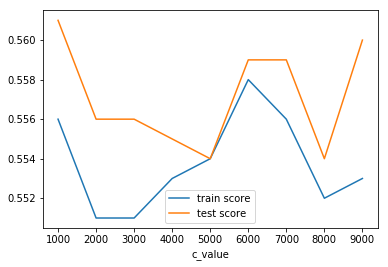

In [38]:
pd.DataFrame({
    'c_value': c_values,
    'train score': train_scores,
    'test score': test_scores
    }).groupby('c_value').sum().plot()

In [39]:
C = 10000
test_scores = []
train_scores = []
c_values = []
#train model
for i in range(5,15):
    train_score, test_score = train_logistic_regression_model(train_features, train_target, test_features, test_target, C*i)
    test_scores.append(test_score)
    train_scores.append(train_score)
    c_values.append(C*i)
    print("Accuracy on training set(C = {}):{}, test set: {}".format(C*i, train_score, test_score))
    if(the_best_test_score < test_score):
        the_best_test_score = test_score
        the_best_c = C*i

Accuracy on training set(C = 50000):0.552, test set: 0.557
Accuracy on training set(C = 60000):0.554, test set: 0.559
Accuracy on training set(C = 70000):0.556, test set: 0.56
Accuracy on training set(C = 80000):0.553, test set: 0.557
Accuracy on training set(C = 90000):0.555, test set: 0.559
Accuracy on training set(C = 100000):0.557, test set: 0.563
Accuracy on training set(C = 110000):0.556, test set: 0.558
Accuracy on training set(C = 120000):0.556, test set: 0.559
Accuracy on training set(C = 130000):0.557, test set: 0.56
Accuracy on training set(C = 140000):0.554, test set: 0.558


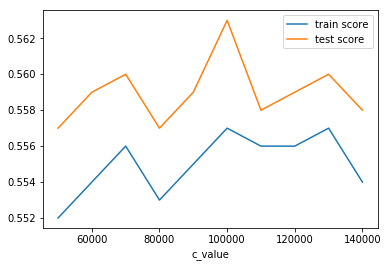

In [40]:
pd.DataFrame({
    'c_value': c_values,
    'train score': train_scores,
    'test score': test_scores
    }).groupby('c_value').sum().plot()

# <a name="logistic_regression_result">Logistic regression result</a>

[Back to content list](#content_list)

In [41]:
#train model with the best C value
C = the_best_c
train_score, test_score = train_logistic_regression_model(train_features, train_target, test_features, test_target, C)
print("Accuracy on training set(C = {}):{}, test set: {}".format(C, train_score, test_score))

Accuracy on training set(C = 100000):0.557, test set: 0.563


# <a name="decision_tree">Decision tree</a>

[Back to content list](#content_list)

In [42]:
#split data
target_index = frame.columns.get_loc('grade')
features_columns = [*range(frame.columns.size)]
target_column = 'grade'
features_columns.remove(target_index)
train_features, train_target, test_features, test_target = split(frame, features_columns, target_column)

In [43]:
# initialize 
decisionTrees = []
for i in range(1, 50):
    decisionTrees.append(DecisionTreeRegressor(max_depth=i))

In [44]:
def fit_and_visualize(trees):
    test_depth = 0
    the_best_test_score = 0
    train_depth = 0
    the_best_train_score = 0
    
    depths = []
    # fit regressions models
    for t in trees:
        t.fit(train_features, train_target)
    # Predict
    predictions = []
    for t in trees:
        predictions.append(t.predict(test_features))
    train_scores = []
    test_scores = []
    depths = []
    for t in trees:
        train_score = t.score(train_features,train_target)
        test_score = t.score(test_features,test_target)
        depth = t.max_depth
        depths.append(depth)
        train_scores.append(train_score)
        test_scores.append(test_score)
        print("{} level tree train score: {}".format(depth,train_score))
        print("{} level tree test score: {}\n".format(depth,test_score))
        if(the_best_test_score < test_score):
            the_best_test_score = test_score
            test_depth = depth
        if(the_best_train_score < train_score):
            the_best_train_score = train_score
            train_depth = depth
    pd.DataFrame({
    'tree_depth': depths,
    'train score': train_scores,
    'test score': test_scores
    }).groupby('tree_depth').sum().plot()
    return train_depth, test_depth

1 level tree train score: 0.3809759038248617
1 level tree test score: 0.3953564411759769

2 level tree train score: 0.5280359322951809
2 level tree test score: 0.5383833488128595

3 level tree train score: 0.6019498030272445
3 level tree test score: 0.6085147889267507

4 level tree train score: 0.6543852823359662
4 level tree test score: 0.657865109348134

5 level tree train score: 0.6915363196276619
5 level tree test score: 0.6896707060500544

6 level tree train score: 0.7211688686266612
6 level tree test score: 0.7122224075052856

7 level tree train score: 0.7494092933353271
7 level tree test score: 0.7255624496822854

8 level tree train score: 0.7821463287323654
8 level tree test score: 0.7332613872493481

9 level tree train score: 0.8173826834952006
9 level tree test score: 0.7406240729487554

10 level tree train score: 0.8493349790423077
10 level tree test score: 0.7423319577992027

11 level tree train score: 0.8827535999444507
11 level tree test score: 0.7424854361907457

12 leve

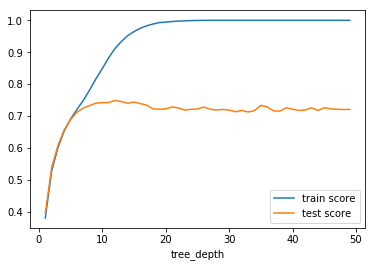

In [45]:
the_best_train_depth, the_best_test_depth = fit_and_visualize(decisionTrees)

In [46]:
print("The best train depth: {}".format(the_best_train_depth))
print("The best test depth: {}".format(the_best_test_depth))

The best train depth: 29
The best test depth: 12


# <a name="dt_result">Decision tree result</a>

How we can see, the best depth for decision tree almost always > than depth for test depth, because when we have really deep tree, this tree just "knows" all cases in train dataset and become retrained.

When we use retrained desicion tree for test dataset, which differend from train - this train has low accuracy.

The same as in the first part.

[Back to content list](#content_list)

# <a name="summary">Summary</a>

I think, that I achieved good accuracy, because all my features based on attantive data analysis:
 - Each column from data frame was analysed by feature:target linear regression
 - Except of analysing with linear regression I analysed data frame with brute force for logistic regression, which really good shows feature importance
 - Was added custom parameters which based on parameters from frame

But, it can be better, because:
 - I bad analysed data feature 
 - The same with floors and coordinates


**Logistic regression:**

Accuracy on training set(C = 100000):0.557, test set: 0.563

[Back to content list](#content_list)